In [1]:
import sys
sys.path.insert(0,'..')
import oqupy
import numpy as np
import matplotlib.pyplot as plt
from oqupy import contractions

In [2]:
oqupy.__version__

'0.3.0'

In [3]:
sigma_z = oqupy.operators.sigma("z")
sigma_plus = oqupy.operators.sigma("+")
sigma_minus = oqupy.operators.sigma("-")

In [4]:
alpha_one = 0.1 #0.25 # change here to 0.1 maybe?
alpha_two = 0.9 
alpha_three = 0.25
nu_c = 227.9
T = 39.3
omega_0 = 0.0
omega_c = -30.4
Omega = 303.9

kappa = 15.2
Gamma_down = 30.4
Gamma_up = 0.8 * Gamma_down


In [5]:
def H_MF(t, a):
    return 0.5 * omega_0 * sigma_z +\
        0.5 * Omega * (a * sigma_plus + np.conj(a) * sigma_minus)

# no-field functions and variables
def gaussian_shape(t, area = 1.0, tau = 1.0, t_0 = 0.0):
    return area/(tau*np.sqrt(np.pi)) * np.exp(-(t-t_0)**2/(tau**2))
detuning = lambda t: 0.0 * t

def hamiltonian_no_field(t):
    return detuning(t)/2.0 * sigma_z \
           + gaussian_shape(t, area = np.pi/2.0, tau = 0.245)/2.0 * sigma_z
###

fractions = [0.5, 0.5] #[1] #[0.5, 0.5]
def field_eom(t, states, field):
    sx_exp_list = [np.matmul(sigma_minus, state).trace() for state in states]
    sx_exp_weighted_sum = sum([fraction*sx_exp for fraction, sx_exp in zip(fractions, sx_exp_list)])
    return -(1j*omega_c+kappa)*field - 0.5j*Omega*sx_exp_weighted_sum

In [6]:
test_field = 1.0+1.0j
test_time = 0.01
test_state = np.array([[0.0,2j],[-2j,1.0]])
print('H_eval =', H_MF(test_time, test_field))
print('EOM_eval =', field_eom(test_time, [test_state, test_state], test_field))

H_eval = [[  0.    +0.j   151.95+151.95j]
 [151.95-151.95j   0.    +0.j  ]]
EOM_eval = (258.29999999999995+15.2j)


In [7]:
gammas = [ lambda t: Gamma_down, lambda t: Gamma_up]
lindblad_operators = [ lambda t: sigma_minus, lambda t: sigma_plus]

In [8]:
def single_field_eom(t, state, a):
    expect_val = np.matmul(sigma_minus, state).trace()
    return -(1j * omega_c + kappa) * a - 0.5j * Omega * expect_val

system_one = oqupy.TimeDependentSystemWithField(
        H_MF,
        single_field_eom,
        gammas=gammas,
        lindblad_operators=lindblad_operators)

system_two = oqupy.TimeDependentSystemWithField(
        H_MF,
        single_field_eom,
        gammas=gammas,
        lindblad_operators=lindblad_operators)

system_no_field_one = oqupy.TimeDependentSystem(hamiltonian_no_field, gammas=gammas,
        lindblad_operators=lindblad_operators)
system_no_field_two = oqupy.TimeDependentSystem(hamiltonian_no_field, gammas=gammas,
        lindblad_operators=lindblad_operators)

In [9]:
correlations_one = oqupy.PowerLawSD(alpha=alpha_one,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)
correlations_two = oqupy.PowerLawSD(alpha=alpha_two,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)

correlations_three = oqupy.PowerLawSD(alpha=alpha_three,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)

bath_one = oqupy.Bath(0.5 * sigma_z, correlations_one)
bath_two = oqupy.Bath(0.5 * sigma_z, correlations_two)
bath_three = oqupy.Bath(0.5 * sigma_z, correlations_three)

In [10]:
initial_field = np.sqrt(0.05)               # Note n_0 = <a^dagger a>(0) = 0.05
initial_state_one = np.array([[0,0],[0,1]]) # spin down
initial_state_two = np.array([[0,0],[0,1]]) # spin down

In [11]:
tempo_parameters = oqupy.TempoParameters(dt=3.2e-3, dkmax=20, epsrel=10**(-5))
start_time = 0.0
end_time = 1.3

process_tensor_one = oqupy.pt_tempo_compute(bath=bath_one,
                                        start_time=start_time,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

process_tensor_two = oqupy.pt_tempo_compute(bath=bath_two,
                                        start_time=0.0,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

process_tensor_three = oqupy.pt_tempo_compute(bath=bath_three,
                                        start_time=0.0,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:09
Elapsed time: 9.2s
--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:25
Elapsed time: 25.6s
--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:11
Elapsed time: 11.9s


In [12]:
initial_state_list = [initial_state_one , initial_state_two]
control_list = [oqupy.Control(system_one.dimension), oqupy.Control(system_two.dimension)]
# super_system = oqupy.SuperTimeDependentSystemWithField([system_one, system_two], field_eom=field_eom)
super_system = oqupy.SuperTimeDependentSystem([system_no_field_one, system_no_field_two])
# super_system = oqupy.SuperTimeDependentSystemWithField([system_one], field_eom=field_eom)
"""dynamics_with_field = oqupy.compute_dynamics_with_field(
        process_tensor=process_tensor,
        system=system_one,
        initial_state=initial_state_one,
        initial_field=initial_field,
        start_time=0.0)"""
"""super_dynamics_with_field = contractions.compute_dynamics_with_field_multiple_systems(super_system, initial_field=initial_field, 
                                                                                        initial_state_list=initial_state_list, 
                                                                                        start_time=start_time,
                                                                                        process_tensor_list = [[process_tensor_one, process_tensor_three], process_tensor_two] # made this a list to prevent object duplication
                                                                                        )"""
super_system_dynamics = contractions.compute_dynamics_multiple_systems(super_system, initial_state_list=initial_state_list, 
                                                                                        start_time=start_time,
                                                                                        process_tensor_list = [[process_tensor_one, process_tensor_three], process_tensor_two] # made this a list to prevent object duplication
                                                                                        )
dynamics_list = super_system_dynamics.dynamics_list

[[<oqupy.process_tensor.SimpleProcessTensor object at 0x000001F050A3A5B0>, <oqupy.process_tensor.SimpleProcessTensor object at 0x000001F053D41430>], [<oqupy.process_tensor.SimpleProcessTensor object at 0x000001F050A3A190>]]
False
False
--> Compute dynamics:
100.0%  406 of  406 [########################################] 00:00:11
Elapsed time: 11.3s


In [20]:
t_list = []
n_list = []
tsz_list = []
sz_list = []

for dynamics in dynamics_list:
    #t_list.append(dynamics.times)
    #n_list.append(np.abs(dynamics.fields)**2)
    t, s_z = dynamics.expectations(0.5*sigma_z, real=True)
    tsz_list.append(t)
    sz_list.append(s_z)

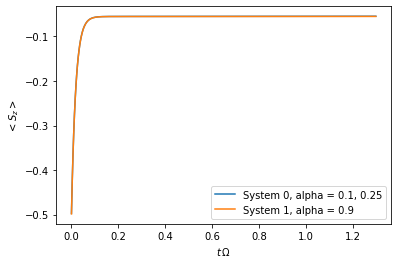

In [21]:
alphas = [alpha_one, alpha_two]
for i in range(len(tsz_list)):# for i in range(len(n_list)):
    if i == 0:
        label = f"System {i}, alpha = {alphas[i]}, {alpha_three}"
    else:
        label = f"System {i}, alpha = {alphas[i]}"
    #plt.plot(t_list[i], n_list[i], label=label)
    plt.plot(tsz_list[i], sz_list[i], label=label)
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<S_z>$')
#plt.xlabel(r'$t$ (ps)')
#plt.ylabel(r'$n/N$')
#plt.ylim((0.0,0.15))
plt.legend(loc='lower right') # upper left

Text(0, 0.5, '$<\\sigma_z>$')

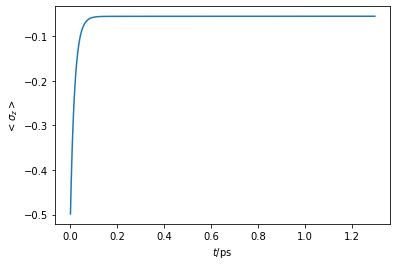

In [26]:
dynamics = oqupy.compute_dynamics(
        process_tensor=process_tensor_two,
        system=system_no_field_two,
        initial_state=initial_state_two,
        start_time=start_time,
        progress_type="silent")
t, s_z = dynamics.expectations(0.5*sigma_z, real=True)
plt.plot(t, s_z)
plt.xlabel(r'$t/$ps')
plt.ylabel(r'$<\sigma_z>$')